In [2]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
import guidedlda
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
#nltk.download() #uncomment, run and download all first time running
#nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:

#download data
survey_comments = pd.read_csv('InfoVizProjectData.csv')

#convert date to datetime object
survey_comments['StartDate'] =  pd.to_datetime(survey_comments['StartDate'], format='%m/%d/%y %H:%M')

#create comment series and convert to proper data type
comments = survey_comments['OpenResponse'].values.astype('U') 

#inititialize lemmatization
lemmatizer = WordNetLemmatizer()

# create a function that preprocesses the data
# note may want to do analysis on all caps comments and exclamation points
# add stop words
# create bigrams 
def preprocessor(text):
    """ Returns clean text from a string (puts in lower case, removes
        punctuation, removes stop words, removes numbers, and lemmatizes words)
        
        Parameters
        ----------
        text : str
            text to be cleaned
    """
    
    text=text.lower() # text to lower case
    text = re.sub(r'\d+', '', text) # remove numbers (may remove this)
    text = re.sub(r'\$', ' price ', text) # may change word
   
    words=re.split("\\s+",text) # split text by space before lemmatizer
    stop_words = list(set(stopwords.words('english')) - {'out', 'off'}) # list of english stopwords from nltk
    stop_words = stop_words + ['platform', 'publisher', 'book', 'like'] # add two more words
    words = [w for w in words if w not in stop_words] # remove stop words
    
    lemma_words=[lemmatizer.lemmatize(word=word) for word in words] #lemmatize
    lemma_words = [w for w in lemma_words if len(w) >= 3] # remove words of certail length
    
    clean_text = ' '.join(lemma_words) # add space between words
    clean_text=re.sub(r'[^\w\s]','',clean_text) # remove punctuation except $
    clean_text=re.sub(' +', ' ', clean_text) # remove any additional spaces
    
    return clean_text

#test the preprocessor
test_string = "this! ma cities$ 5in it is @@@ cc a companies TEST!!@#$%^&*(){}: $1000. heaaasfdfr been had cities"
preprocessor(test_string)

#run preprocessor for all rows (don't do in vectorizer)
comments_processed = pd.Series([preprocessor(row) for row in comments])

# remove infrequent words (can change the number but need this for visualization)
comment_list = comments_processed.str.split().tolist() 

# compute global word frequency
c = Counter(chain.from_iterable(comment_list))

# filter, join, and re-assign
survey_comments['clean'] = [' '.join([j for j in i if c[j] > 10]) for i in comment_list]

# remove comments with empty length
survey_comments['CommentLength'] = survey_comments['clean'].str.len()
df_filtered = survey_comments[survey_comments['CommentLength'] > 0]
# reset jndex to sequential numbers
df_filtered.reset_index(drop=True, inplace=True)
clean_comments = df_filtered['clean']   

c.most_common(50)

[('access', 2119),
 ('page', 1937),
 ('book', 1903),
 ('use', 1898),
 ('class', 1890),
 ('time', 1705),
 ('get', 1629),
 ('would', 1539),
 ('out', 1490),
 ('course', 1442),
 ('easy', 1416),
 ('product', 1336),
 ('textbook', 1301),
 ('one', 1281),
 ('need', 1267),
 ('work', 1264),
 ('find', 1241),
 ('price', 976),
 ('hard', 916),
 ('also', 892),
 ('assignment', 876),
 ('able', 841),
 ('could', 801),
 ('website', 799),
 ('cant', 784),
 ('make', 746),
 ('navigate', 744),
 ('it', 731),
 ('homework', 728),
 ('problem', 727),
 ('really', 726),
 ('online', 724),
 ('way', 716),
 ('code', 700),
 ('great', 683),
 ('even', 681),
 ('difficult', 678),
 ('expensive', 678),
 ('issue', 677),
 ('publisher', 661),
 ('material', 656),
 ('help', 639),
 ('much', 636),
 ('student', 631),
 ('money', 624),
 ('program', 605),
 ('take', 604),
 ('option', 601),
 ('sometimes', 595),
 ('good', 594)]

In [4]:
# stop_words - list of words to remove 
# preprocessor - customizable preprocessor function preprocessor = preprocessor (already run)
vectorizer = CountVectorizer(max_df=0.95, # remove words that appear in 95% of documents
                                min_df=10, # ignore words in only 10 documents
                                ngram_range=(1, 2)) #using a unigram (1,1) or bigram (2,2)

comment_matrix = vectorizer.fit_transform(clean_comments)

## Since LDA is a probabilistic model, you will get some differences in the end 
## result each time you run it. Hence, it is a good idea to set the random_state 
## parameter to a fixed number and save the model locally using pickle to preserve 
## how it infers the topics later on. 

#### Guided LDA
#https://github.com/vi3k6i5/GuidedLDA
#https://medium.com/analytics-vidhya/how-i-tackled-a-real-world-problem-with-guidedlda-55ee803a6f0d

#get vocab of dataset
vocab = vectorizer.get_feature_names()
word_index = dict((word_vocab, index) for index, word_vocab in enumerate(vocab))

# create topic list
topic_keywords = [['log', 'out', 'log out', 'time', 'out', 'time out', 'logged'], #1
['access', 'code', 'access code', 'course', 'course code', 'purchasing', 'purchase', 'purchased', 'subscription', 'bookstore'], #2
['page', 'number', 'page number'], #3
['price', 'expensive', 'pay', 'money', 'save', 'cost', 'overpriced'], #4
['navigate', 'find', 'hard navigate', 'hard find', 'figure out', 'hard use', 'navigation', 'user friendly', 'accessible'], #5
['product', 'rental', 'rent', 'print'], #6
['customer', 'customer service', 'service', 'support', 'customer support'], #7
['app', 'tablet', 'phone', 'mobile', 'ipad'], #8
['load', 'crash', 'glitchy', 'slow', 'bug', 'flash']] #9

#grid search best priors
alpha = [.001, .01, .1, 1] #distribution over topics
eta = [.001, .01, .1, 1] # distribution over words

seed_topics = {}
for topic_id, topic in enumerate(topic_keywords):
    for word in topic:
        seed_topics[word_index[word]] = topic_id
        
model = guidedlda.GuidedLDA(n_topics=10, n_iter=1000, alpha = .001, eta = .1, random_state=1, refresh=100)
model.fit(comment_matrix, seed_topics=seed_topics, seed_confidence=0.3)

#check top words
n_top_words = 10
topic_word = model.topic_word_ # word topic distribution
for i, topic_dist in enumerate(topic_word): # i is topic topic_dist is distribution of words in topic
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1] #print top 20 words in topic
    print('Topic {}:   {}'.format(i, ', '.join(topic_words)))

# create document topic distribution
doc_topic = model.transform(comment_matrix)

# view words in document
n = comment_matrix.toarray()
doc_topic = model.transform(n)
for i in range(9):
    print("top topic: {} Document: {}".format(doc_topic[i].argmax(),', '.join(np.array(vocab)[list(reversed(n[i,:].argsort()))[0:5]])))

INFO:guidedlda:n_documents: 16793
INFO:guidedlda:vocab_size: 2908
INFO:guidedlda:n_words: 189624
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -2373976
INFO:guidedlda:<100> log likelihood: -1357949
INFO:guidedlda:<200> log likelihood: -1344548
INFO:guidedlda:<300> log likelihood: -1337743
INFO:guidedlda:<400> log likelihood: -1331942
INFO:guidedlda:<500> log likelihood: -1328343
INFO:guidedlda:<600> log likelihood: -1325825
INFO:guidedlda:<700> log likelihood: -1323004
INFO:guidedlda:<800> log likelihood: -1321568
INFO:guidedlda:<900> log likelihood: -1320413
INFO:guidedlda:<999> log likelihood: -1319576


Topic 0:   out, time, log, get, page, sign, take, back, load, open
Topic 1:   access, course, code, class, product, find, book, cant, get, access code
Topic 2:   page, numbers, page numbers, number, search, page number, book, would, textbook, find
Topic 3:   price, money, class, expensive, pay, book, one, student, much, use
Topic 4:   easy, use, navigate, find, easy use, hard, user, easy navigate, friendly, difficult
Topic 5:   product, book, would, textbook, use, get, access, class, price, option
Topic 6:   customer, issue, service, get, support, time, customer service, class, never, problem
Topic 7:   access, book, app, use, would, work, read, great, need, textbook
Topic 8:   work, time, assignment, get, use, lab, slow, load, issue, website
Topic 9:   answer, question, problem, would, wrong, help, homework, video, practice, get
top topic: 4 Document: super, zoom, gain access, get access, get
top topic: 1 Document: code work, code, work, zoom, garbage
top topic: 5 Document: sign, prin

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

vis = pyLDAvis.sklearn.prepare(model, comment_matrix, vectorizer, sort_topics=False)
pyLDAvis.enable_notebook()
#pyLDAvis.save_html(vis, 'lda.html')
pyLDAvis.display(vis)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [8]:
#make the dataframe with the final comments

#https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
#https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

# topic names for columns in dataframe
topicnames = ["LoggingIn", "AccessPurchase", "PageNumberSearch", 
              "Price", "Navigation", "Products", "CustomerSupport",
              "OtherDevices", "Technical", "Other"]

# Make the pandas dataframe index=docnames
df_document_topic = pd.DataFrame(np.round(doc_topic, 2), columns=topicnames)
df_document_topic = df_document_topic.applymap(lambda x: 1 if x >= 0.25 else 0)
df_document_topic.sum()/len(df_document_topic)
#df_document_topic["sum"] = df_document_topic.sum(axis=1)
df_merged = df_filtered.merge(df_document_topic, how='outer', left_index=True, right_index=True)
#a = df_merged[df_merged['sum'] == 0]['OpenResponse']

sid = SentimentIntensityAnalyzer()

test = 'this product is amazing and has been very useful'
print(sid.polarity_scores(test))

# add sentiment scores to dataframe
df_merged['sentiment_scores'] = df_merged['OpenResponse'].apply(
    lambda OpenResponse: sid.polarity_scores(OpenResponse))

# extract compound column (normalized sum of lexicon ratings)
df_merged['compound'] = df_merged['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])

# categorize the compound as negative or positive
compound_sentiment = [] # define an empty list

for i in df_merged['compound']: # iterate through compound values and assign sentiment
    if i >= 0.2:
        temp_sentiment = 'positive'
    elif i <= -0.2:
        temp_sentiment = 'negative'
    else:
        temp_sentiment = 'neutral'

    compound_sentiment.append(temp_sentiment)

df_merged['compound_sentiment'] = compound_sentiment # add the defined sentiments to dataframe

# save survey comments as dataframe for dashboard code
df_merged.to_csv('final_df.csv')


{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.7902}


/Users/olliepenglase/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


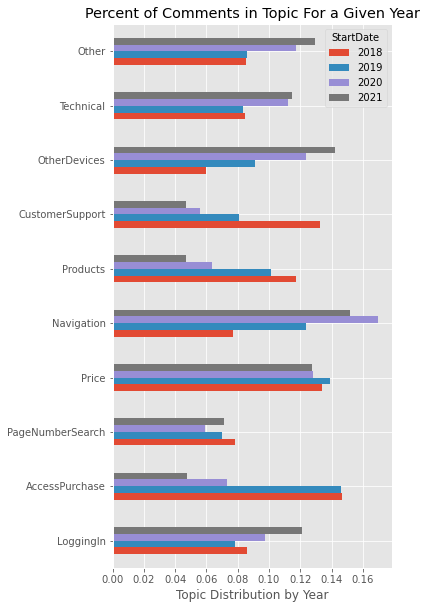

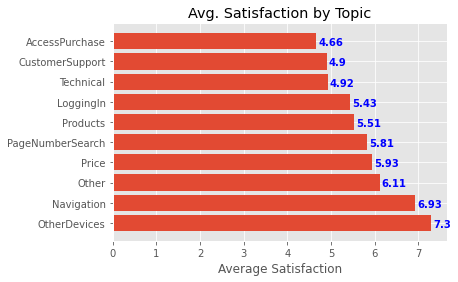

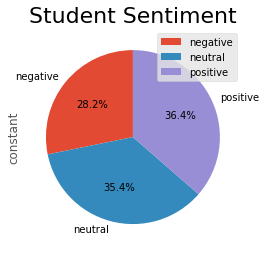

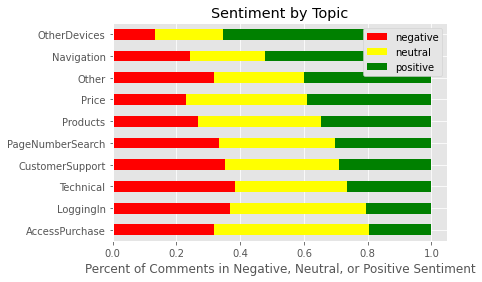

In [9]:
# Topic dist by date

topic_date = df_merged.groupby(pd.DatetimeIndex(df_merged['StartDate']).year)[topicnames].sum()
topic_date["sum"] = topic_date.sum(axis=1)
df_new = topic_date.loc[:,topicnames].div(topic_date["sum"], axis=0)

plt.style.use('ggplot')
ax = df_new.T.plot.barh(rot=0, figsize=(5,10))
ax.set_xlabel('Topic Distribution by Year')
ax.set_title('Percent of Comments in Topic For a Given Year')

# Satisfaction by topic

#df_merged.groupby(['name', 'id', 'dept'])['total_sale'].mean().reset_index()
topic_sat = [sum(df_merged[i]*df_merged["OverallSatisfaction"])/sum(df_merged[i]) for i in topicnames]
topic_sat_sorted = zip(topic_sat, topicnames)
sorted_pairs = sorted(topic_sat_sorted)
tuples = zip(*sorted_pairs)
topic_sat, topicnames = [ list(tuple) for tuple in  tuples]

y_pos = np.arange(len(topicnames))

plt.style.use('ggplot')
fig, ax = plt.subplots()

hbars = ax.barh(y_pos, topic_sat)
ax.set_yticks(y_pos)
ax.set_yticklabels(topicnames)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Satisfaction')
ax.set_title('Avg. Satisfaction by Topic')
# Label with specially formatted floats
for i, v in enumerate(topic_sat):
    ax.text(v + .05, i + .2, round(v,2), color='blue', fontweight='bold')

# Sentiment plots

# plot pie chart of polarities
df_merged['constant'] = 1
sentiment_plot = df_merged.groupby(['compound_sentiment']).sum()['constant'].to_frame()
sentiment_plot.plot.pie(y='constant', autopct='%1.1f%%', startangle=90)
plt.title('Student Sentiment', fontsize=22)

sentiment_plot = df_merged.groupby(['compound_sentiment'])["LoggingIn", "AccessPurchase", "PageNumberSearch", 
              "Price", "Navigation", "Products", "CustomerSupport",
              "OtherDevices", "Technical", "Other"].sum()
sentiment_plot = sentiment_plot/sentiment_plot.sum()
sentiment_plot = sentiment_plot.T.sort_values(by=['positive'])

ax = sentiment_plot.plot.barh(stacked=True, color={"negative": "red", "neutral": "yellow", "positive": "green"})
ax.set_xlabel('Percent of Comments in Negative, Neutral, or Positive Sentiment')
ax.set_title('Sentiment by Topic')
ax.legend(loc='upper right', framealpha=1.0)